In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 80

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.55 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

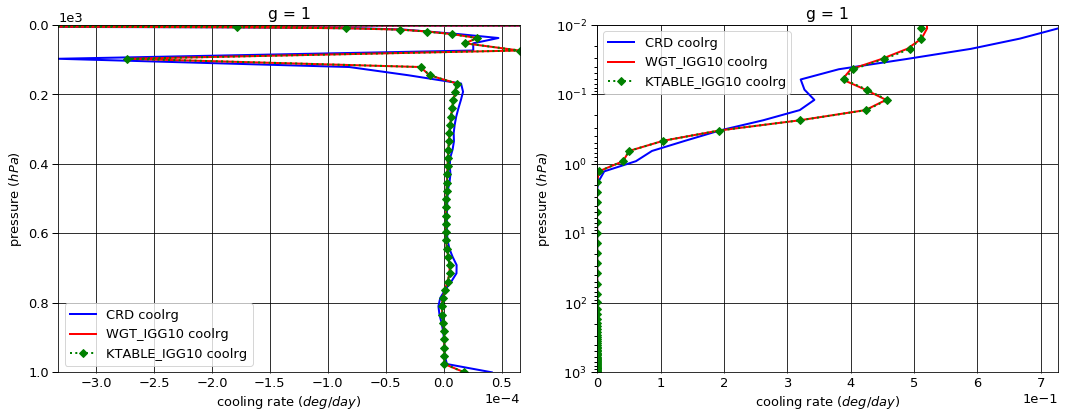

# Figure: cooling rate g-group 2

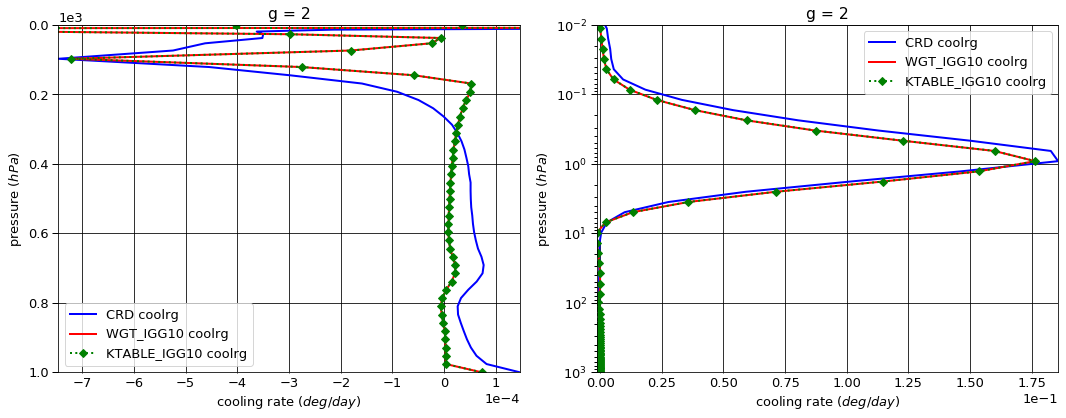

# Figure: cooling rate g-group 3

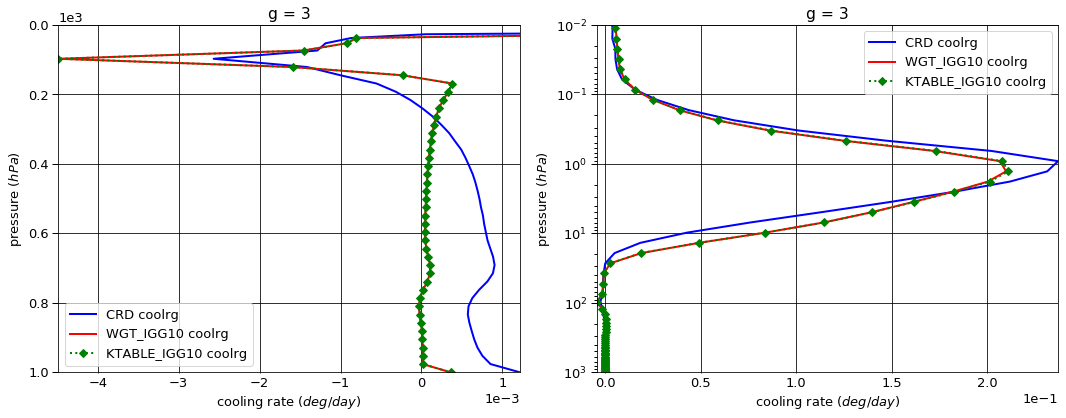

# Figure: cooling rate g-group 4

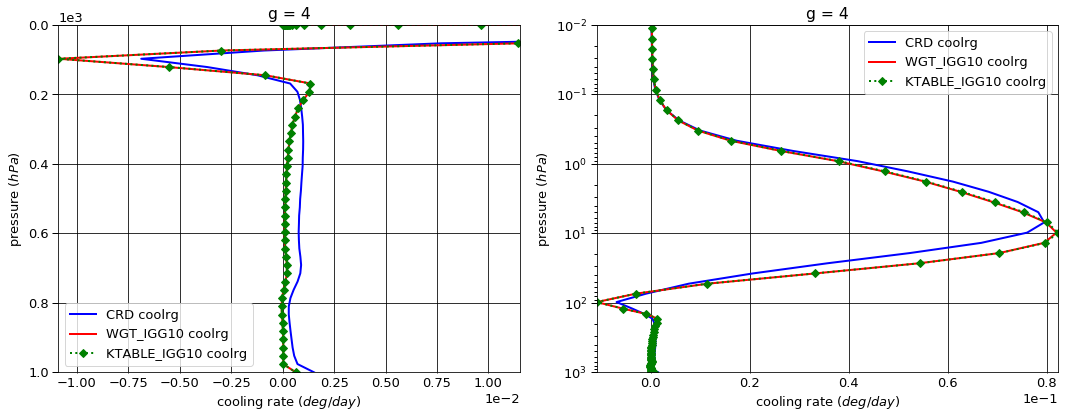

# Figure: cooling rate g-group 5

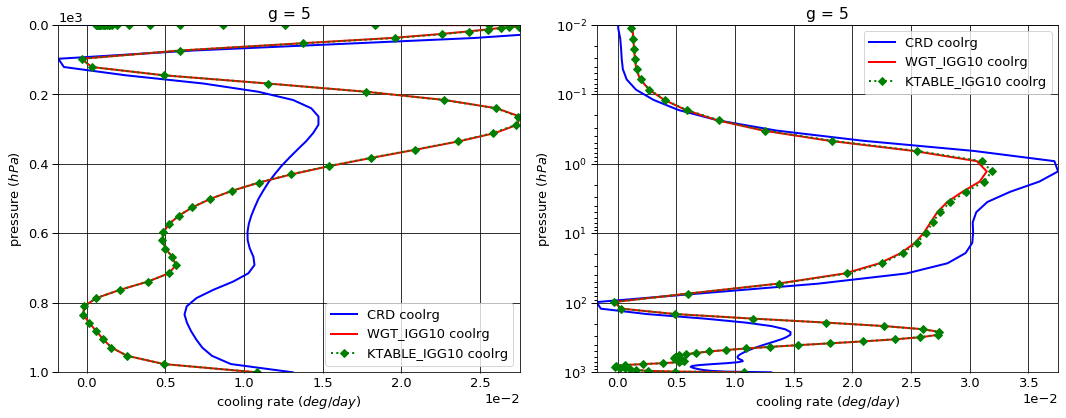

# Figure: cooling rate g-group 6

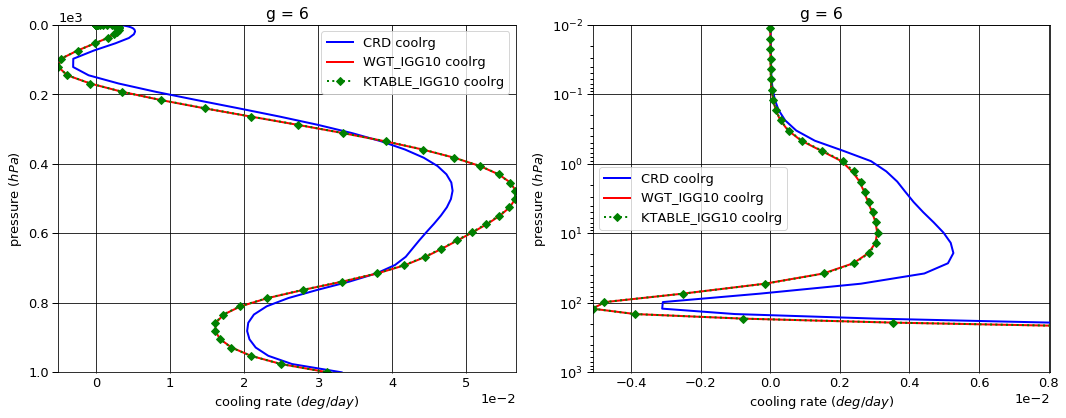

# Figure: cooling rate g-group 7

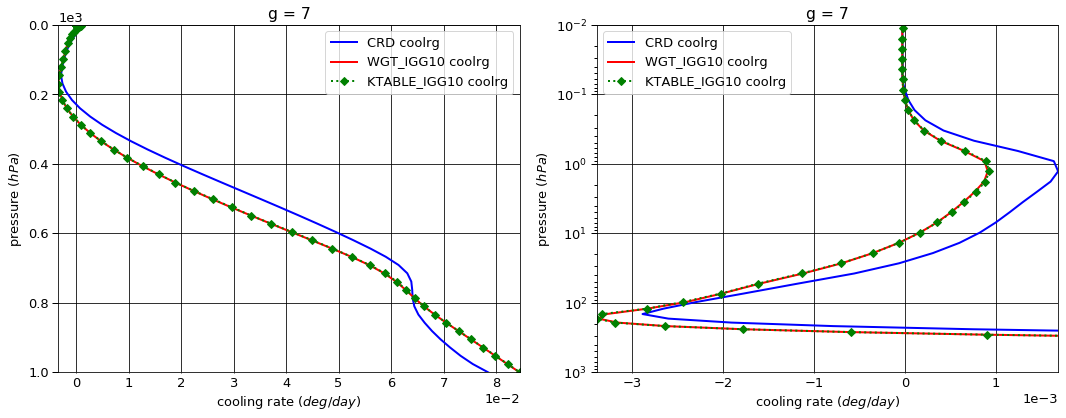

# Figure: cooling rate g-group 8

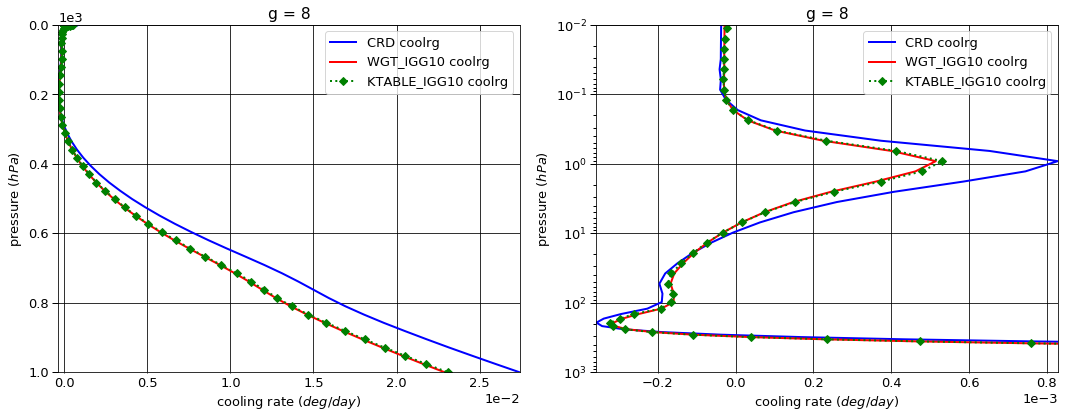

# Figure: cooling rate g-group 9

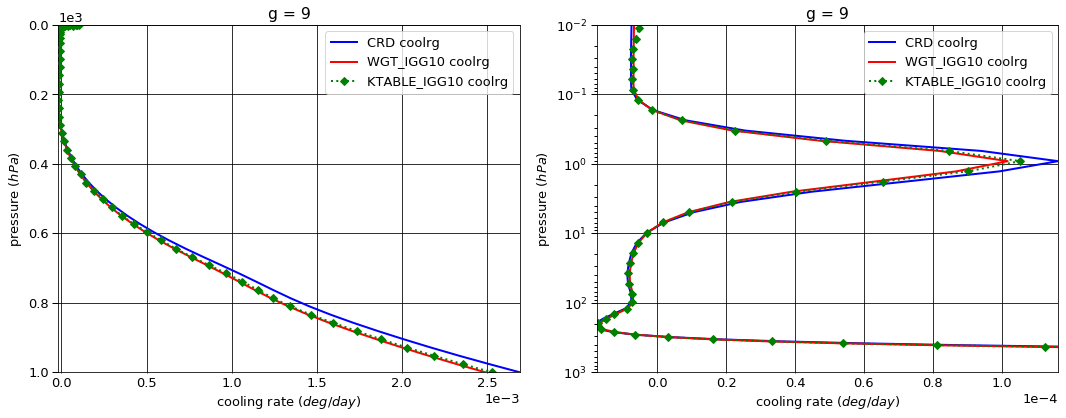

# Figure: cooling rate g-group total

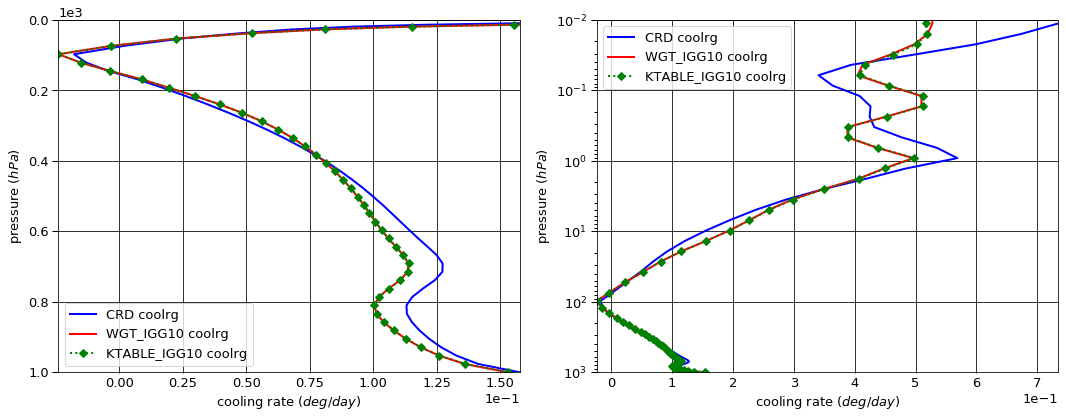

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.021112  0.000000  -0.021112
  1013.0   76     -0.050521  0.050398  -0.000123
2 0.0      1      -0.041708  0.000000  -0.041708
  1013.0   76     -0.069786  0.068295  -0.001491
3 0.0      1      -0.225916  0.000000  -0.225916
  1013.0   76     -0.426028  0.395753  -0.030275
4 0.0      1      -0.312106  0.000000  -0.312106
  1013.0   76     -0.825448  0.810574  -0.014874
5 0.0      1      -1.606656  0.000000  -1.606656
  1013.0   76     -3.466884  3.119436  -0.347448
6 0.0      1      -3.742058  0.000000  -3.742058
  1013.0   76     -6.739534  6.348810  -0.390725
7 0.0      1      -8.209982  0.000000  -8.209982
  1013.0   76     -9.949945  5.889857  -4.060088
8 0.0      1     -10.478031  0.000000 -10.478031
  1013.0   76    -10.714574  1.182134  -9.532440
9 0.0      1      -6.232980  0.000000  -6.232980
  1013.0   76     -6.249014  0.097043  -6.151971


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.020036  0.000000  -0.020036
  1013.0   76     -0.050521  0.050471  -0.000049
2 0.0      1      -0.042437  0.000000  -0.042437
  1013.0   76     -0.069786  0.069582  -0.000203
3 0.0      1      -0.203763  0.000000  -0.203763
  1013.0   76     -0.426028  0.425022  -0.001006
4 0.0      1      -0.294899  0.000000  -0.294899
  1013.0   76     -0.825448  0.823685  -0.001764
5 0.0      1      -1.230008  0.000000  -1.230008
  1013.0   76     -3.466884  3.417104  -0.049780
6 0.0      1      -3.688550  0.000000  -3.688550
  1013.0   76     -6.739534  6.438458  -0.301077
7 0.0      1      -8.515743  0.000000  -8.515743
  1013.0   76     -9.949945  5.273515  -4.676430
8 0.0      1     -10.531765  0.000000 -10.531765
  1013.0   76    -10.714574  0.937831  -9.776743
9 0.0      1      -6.234388  0.000000  -6.234388
  1013.0   76     -6.249014  0.088905  -6.160109


KTABLE_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.020051  0.000000  -0.020051
  1013.0   76     -0.050521  0.050471  -0.000049
2 0.0      1      -0.042441  0.000000  -0.042441
  1013.0   76     -0.069786  0.069583  -0.000203
3 0.0      1      -0.203920  0.000000  -0.203920
  1013.0   76     -0.426028  0.425022  -0.001006
4 0.0      1      -0.295160  0.000000  -0.295160
  1013.0   76     -0.825448  0.823685  -0.001763
5 0.0      1      -1.228730  0.000000  -1.228730
  1013.0   76     -3.466884  3.417112  -0.049772
6 0.0      1      -3.684773  0.000000  -3.684773
  1013.0   76     -6.739534  6.438742  -0.300792
7 0.0      1      -8.510067  0.000000  -8.510067
  1013.0   76     -9.949945  5.284641  -4.665304
8 0.0      1     -10.529526  0.000000 -10.529526
  1013.0   76    -10.714574  0.946487  -9.768087
9 0.0      1      -6.234123  0.000000  -6.234123
  1013.0   76     -6.249014  0.090284  -6.158730


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.076203e-03  0.000000  0.001076
  1013.0   76     6.938894e-18  0.000073  0.000073
2 0.0      1     -7.283990e-04  0.000000 -0.000728
  1013.0   76     0.000000e+00  0.001288  0.001288
3 0.0      1      2.215336e-02  0.000000  0.022153
  1013.0   76     0.000000e+00  0.029269  0.029269
4 0.0      1      1.720669e-02  0.000000  0.017207
  1013.0   76     0.000000e+00  0.013110  0.013110
5 0.0      1      3.766482e-01  0.000000  0.376648
  1013.0   76     0.000000e+00  0.297668  0.297668
6 0.0      1      5.350810e-02  0.000000  0.053508
  1013.0   76     0.000000e+00  0.089648  0.089648
7 0.0      1     -3.057612e-01  0.000000 -0.305761
  1013.0   76     0.000000e+00 -0.616343 -0.616343
8 0.0      1     -5.373400e-02  0.000000 -0.053734
  1013.0   76     0.000000e+00 -0.244303 -0.244303
9 0.0      1     -1.407800e-03  0.000000 -0.001408
  1013.0   76     0.000000e+00 -0.008138 -0.008138


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.060645e-03  0.000000  0.001061
  1013.0   76     6.938894e-18  0.000073  0.000073
2 0.0      1     -7.323630e-04  0.000000 -0.000732
  1013.0   76     0.000000e+00  0.001288  0.001288
3 0.0      1      2.199601e-02  0.000000  0.021996
  1013.0   76     0.000000e+00  0.029269  0.029269
4 0.0      1      1.694583e-02  0.000000  0.016946
  1013.0   76     0.000000e+00  0.013111  0.013111
5 0.0      1      3.779259e-01  0.000000  0.377926
  1013.0   76     0.000000e+00  0.297676  0.297676
6 0.0      1      5.728510e-02  0.000000  0.057285
  1013.0   76     0.000000e+00  0.089932  0.089933
7 0.0      1     -3.000847e-01  0.000000 -0.300085
  1013.0   76     0.000000e+00 -0.605216 -0.605216
8 0.0      1     -5.149500e-02  0.000000 -0.051495
  1013.0   76     0.000000e+00 -0.235647 -0.235647
9 0.0      1     -1.143500e-03  0.000000 -0.001143
  1013.0   76     0.000000e+00 -0.006759 -0.006759

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.741654
  1001.112500 75     0.000041
2 0.000312    1     -0.001036
  1001.112500 75     0.000146
3 0.000312    1      0.000795
  1001.112500 75     0.001215
4 0.000312    1      0.000085
  1001.112500 75     0.001522
5 0.000312    1     -0.000231
  1001.112500 75     0.013090
6 0.000312    1      0.000006
  1001.112500 75     0.033168
7 0.000312    1     -0.000033
  1001.112500 75     0.078483
8 0.000312    1     -0.000034
  1001.112500 75     0.027407
9 0.000312    1     -0.000007
  1001.112500 75     0.002694


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      4.012471e-01
  1001.112500 75     1.781848e-05
2 0.000312    1     -3.442068e-03
  1001.112500 75     7.242137e-05
3 0.000312    1      2.765241e-03
  1001.112500 75     3.611506e-04
4 0.000312    1      1.330866e-04
  1001.112500 75     6.359437e-04
5 0.000312    1      8.575202e-04
  1001.112500 75     1.079941e-02
6 0.000312    1      7.974253e-07
  1001.112500 75     3.126908e-02
7 0.000312    1     -3.223956e-05
  1001.112500 75     8.447299e-02
8 0.000312    1     -2.559941e-05
  1001.112500 75     2.289762e-02
9 0.000312    1     -6.120507e-06
  1001.112500 75     2.490642e-03


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.623985e-01
  1001.112500 75     1.781315e-05
2 0.000312    1     -2.607019e-03
  1001.112500 75     7.237298e-05
3 0.000312    1      1.811387e-03
  1001.112500 75     3.610761e-04
4 0.000312    1     -4.871901e-06
  1001.112500 75     6.359184e-04
5 0.000312    1      5.814659e-04
  1001.112500 75     1.080147e-02
6 0.000312    1      3.192787e-07
  1001.112500 75     3.125388e-02
7 0.000312    1     -1.405031e-05
  1001.112500 75     8.453137e-02
8 0.000312    1     -4.969958e-06
  1001.112500 75     2.308953e-02
9 0.000312    1     -1.336123e-06
  1001.112500 75     2.529868e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.404070e-01
  1001.112500 75    -2.366185e-05
2 0.000312    1     -2.406175e-03
  1001.112500 75    -7.389303e-05
3 0.000312    1      1.970729e-03
  1001.112500 75    -8.541958e-04
4 0.000312    1      4.795559e-05
  1001.112500 75    -8.865183e-04
5 0.000312    1      1.088301e-03
  1001.112500 75    -2.290226e-03
6 0.000312    1     -5.214900e-06
  1001.112500 75    -1.899200e-03
7 0.000312    1      1.164766e-06
  1001.112500 75     5.989607e-03
8 0.000312    1      8.193642e-06
  1001.112500 75    -4.509289e-03
9 0.000312    1      6.806100e-07
  1001.112500 75    -2.028718e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.379256
  1001.112500 75    -0.000024
2 0.000312    1     -0.001571
  1001.112500 75    -0.000074
3 0.000312    1      0.001017
  1001.112500 75    -0.000854
4 0.000312    1     -0.000090
  1001.112500 75    -0.000887
5 0.000312    1      0.000812
  1001.112500 75    -0.002288
6 0.000312    1     -0.000006
  1001.112500 75    -0.001914
7 0.000312    1      0.000019
  1001.112500 75     0.006048
8 0.000312    1      0.000029
  1001.112500 75    -0.004317
9 0.000312    1      0.000005
  1001.112500 75    -0.000164

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.870550,0.000000,-30.870550
1013.0,76,-38.491734,17.962299,-20.529435



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.761588,0.000000,-30.761588
1013.0,76,-38.491734,17.524573,-20.967161



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.748792,0.000000,-30.748792
1013.0,76,-38.491734,17.546027,-20.945707



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.108961,0.000000,0.108961
1013.0,76,0.000000,-0.437726,-0.437726



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.121758,0.000000,0.121758
1013.0,76,0.000000,-0.416273,-0.416272


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.741199
1001.112500,75,0.157767



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.401498
1001.112500,75,0.153017



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.362159
1001.112500,75,0.153293



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.339701
1001.112500,75,-0.004750



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.379040
1001.112500,75,-0.004474


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001313,0.001276
2,0.001813,0.001769
3,0.011062,0.010838
4,0.021438,0.020926
5,0.090000,0.088449
6,0.174937,0.171284
7,0.258125,0.257021
8,0.278438,0.282004
9,0.162875,0.166433


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.758133e-19
2,1.296272e-20
3,9.557418e-22
4,6.761756e-22
5,5.021768e-23
6,1.772266e-22
7,1.332107e-23
8,1.001266e-24
9,1.011442e-25


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.758133e-19,NaN,0.001313,0.001276,0.001313,0.001276,1.0
2,1.296272e-20,0.073730,0.001813,0.001769,0.003125,0.003045,1.0
3,9.557418e-22,0.073730,0.011062,0.010838,0.014187,0.013883,1.0
4,6.761756e-22,0.707488,0.021438,0.020926,0.035625,0.034809,10.0
5,5.021768e-23,0.074267,0.090000,0.088449,0.125625,0.123258,10.0
6,1.772266e-22,3.529167,0.174937,0.171284,0.300562,0.294542,500.0
7,1.332107e-23,0.075164,0.258125,0.257021,0.558688,0.551563,500.0
8,1.001266e-24,0.075164,0.278438,0.282004,0.837125,0.833567,500.0
9,1.011442e-25,0.101016,0.162875,0.166433,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.340958e-19  2.797332e-19   1.909305  2.423286e-03
      2 0.000312     9.393570e-21  7.170017e-21   1.310118  4.148543e-05
      3 0.000312     7.921814e-22  4.017121e-22   1.972013  3.573313e-06
      4 0.000312     6.797175e-24  6.051994e-24   1.123130  3.479732e-08
      5 0.000312     1.279237e-23  4.764072e-24   2.685176  5.071709e-08
      6 0.000312     1.225656e-25  1.194638e-25   1.025964  6.389466e-10
      7 0.000312     1.160637e-25  9.286415e-26   1.249823  5.529776e-10
      8 0.000312     6.316904e-26  1.991123e-26   3.172534  2.885871e-10
      9 0.000312     2.023755e-26  3.030932e-27   6.677004  1.025729e-10
2     1 0.000750     5.370596e-19  2.809851e-19   1.911346  9.812915e-04
      2 0.000750     9.471072e-21  7.221749e-21   1.311465  1.683656e-05
      3 0.000750     7.996541e-22  4.045468e-22   1.976667  1.452249e-06
      4 0.000750     6.928040e-24  6.171862e-24   1.122520  1.428789e-08
      5 0.000750     1.290610e-23  4.797177e-24   2.690354  2.060190e-08
      6 0.000750     1.241673e-25  1.210194e-25   1.026011  2.607153e-10
      7 0.000750     1.175431e-25  9.389488e-26   1.251859  2.254080e-10
      8 0.000750     6.415940e-26  2.008031e-26   3.195140  1.180004e-10
      9 0.000750     2.053866e-26  3.052794e-27   6.727826  4.192724e-11
3     1 0.001052     5.431295e-19  2.835273e-19   1.915617  1.391134e-03
      2 0.001052     9.627225e-21  7.323486e-21   1.314569  2.396437e-05
      3 0.001052     8.146219e-22  4.097304e-22   1.988190  2.072592e-06
      4 0.001052     7.123111e-24  6.344097e-24   1.122793  2.059992e-08
      5 0.001052     1.313590e-23  4.860054e-24   2.702831  2.937928e-08
      6 0.001052     1.270341e-25  1.237904e-25   1.026203  3.740237e-10
      7 0.001052     1.205091e-25  9.592262e-26   1.256316  3.235747e-10
      8 0.001052     6.620369e-26  2.041616e-26   3.242710  1.705730e-10
      9 0.001052     2.116267e-26  3.096774e-27   6.833780  6.057728e-11
4     1 0.001476     5.493232e-19  2.861215e-19   1.919895  1.973062e-03
      2 0.001476     9.788469e-21  7.428362e-21   1.317716  3.413029e-05
      3 0.001476     8.301422e-22  4.151410e-22   1.999663  2.960004e-06
      4 0.001476     7.340947e-24  6.538020e-24   1.122809  2.978314e-08
      5 0.001476     1.337422e-23  4.925272e-24   2.715427  4.192519e-08
      6 0.001476     1.301046e-25  1.267606e-25   1.026381  5.373422e-10
      7 0.001476     1.236098e-25  9.803475e-26   1.260877  4.648737e-10
      8 0.001476     6.834346e-26  2.076365e-26   3.291496  2.467677e-10
      9 0.001476     2.181408e-26  3.142002e-27   6.942733  8.758877e-11
5     1 0.002070     5.555544e-19  2.887336e-19   1.924107  2.797665e-03
      2 0.002070     9.952969e-21  7.535374e-21   1.320833  4.860177e-05
      3 0.002070     8.460528e-22  4.207689e-22   2.010731  4.227124e-06
      4 0.002070     7.586550e-24  6.758919e-24   1.122450  4.317485e-08
      5 0.002070     1.361842e-23  4.992441e-24   2.727807  5.982386e-08
      6 0.002070     1.333863e-25  1.299387e-25   1.026533  7.726115e-10
      7 0.002070     1.268161e-25  1.002137e-25   1.265457  6.678678e-10
      8 0.002070     7.055415e-26  2.111943e-26   3.340722  3.569371e-10
      9 0.002070     2.248497e-26  3.187960e-27   7.053090  1.266142e-10
6     1 0.002904     5.618171e-19  2.913635e-19   1.928235  3.967082e-03
      2 0.002904     1.012105e-20  7.645001e-21   1.323878  6.922502e-05
      3 0.002904     8.624023e-22  4.266937e-22   2.021127  6.038668e-06
      4 0.002904     7.869936e-24  7.016790e-24   1.121586  6.283863e-08
      5 0.002904     1.386907e-23  5.062166e-24   2.739750  8.538855e-08
      6 0.002904     1.369394e-25  1.333848e-25   1.026649  1.112565e-09
      7 0.002904     1.301414e-25  1.024719e-25   1.270020  9.598840e-10
      8 0.002904     7.283857e-26  2.148506e-26   3.390195  5.163754e-10
      9 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
